In [94]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation
from tensorflow.keras import Model
from keras.datasets import mnist
from __future__ import absolute_import, division, print_function, unicode_literals
tf.keras.backend.set_floatx('float64')

LOG_DIR = "../saved_models/"
MODEL_NAME = "10_1_19_mnist_am_weights"

# Data

In [95]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Model

In [105]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = Dense(200, name='d1')
        self.r1 = Activation('relu', name = 'r1')
        self.d2 = Dense(100, name='d2')
        self.r2 = Activation('relu', name = 'r1')
        self.d3 = Dense(10, name='d3')
        self.s1 = Activation('softmax', name = 's1')

    def call(self, x):
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        x = self.r2(x)
        x = self.d3(x)
        return self.s1(x)
model = MyModel()

# Loss

In [97]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Train

In [106]:
# define own function
@tf.function
def train_step(model,images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(model, images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
def train(model, train_ds, test_ds, EPOCHS=10): 
    for epoch in range(EPOCHS):
        for images, labels in train_ds:
            train_step(model, images, labels)

        for test_images, test_labels in test_ds:
            test_step(model, test_images, test_labels)
        
        template = 'Epoch {}, Loss: {}, Accuracy: {}%, Test Loss: {}, Test Accuracy: {}%'
        print(template.format(epoch+1,
                            train_loss.result().numpy(),
                            train_accuracy.result().numpy()*100,
                            test_loss.result().numpy(),
                            test_accuracy.result().numpy()*100))
        
            
        
        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
            
    
def evaluate(model, test_ds):
    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels)
    loss = test_loss.result().numpy()
    accuracy = test_accuracy.result().numpy() * 100
    test_loss.reset_states()
    test_accuracy.reset_states()
    return loss, accuracy


In [103]:
## redo model with early stopping

In [107]:
train(model, train_ds, test_ds, EPOCHS = 20)
evaluate(model, test_ds)

Epoch 1, Loss: 0.08821232194641548, Accuracy: 97.33833333333334%, Test Loss: 0.09772774874185845, Test Accuracy: 96.87%
Epoch 2, Loss: 0.07506161398005982, Accuracy: 97.64166666666667%, Test Loss: 0.0994399381377156, Test Accuracy: 96.69%
Epoch 3, Loss: 0.05161230247200777, Accuracy: 98.335%, Test Loss: 0.0885415022874109, Test Accuracy: 97.45%
Epoch 4, Loss: 0.038096742763832056, Accuracy: 98.72833333333332%, Test Loss: 0.0797294932464412, Test Accuracy: 97.82%
Epoch 5, Loss: 0.02928351877636742, Accuracy: 99.03666666666666%, Test Loss: 0.08665953248407478, Test Accuracy: 97.71%
Epoch 6, Loss: 0.024291771268929976, Accuracy: 99.195%, Test Loss: 0.08844355593557263, Test Accuracy: 97.99%
Epoch 7, Loss: 0.02190714556252836, Accuracy: 99.23833333333333%, Test Loss: 0.09146268027043566, Test Accuracy: 97.8%
Epoch 8, Loss: 0.01766419904843448, Accuracy: 99.40833333333333%, Test Loss: 0.09335705906790304, Test Accuracy: 98.02%
Epoch 9, Loss: 0.015504009059315165, Accuracy: 99.46166666666667

(0.1256575028316801, 97.83)

# Save Model

In [37]:
model.save_weights(os.path.join(LOG_DIR, MODEL_NAME))

# Load Model

In [42]:
# to do fix this section
x = MyModel()
x.load_weights(os.path.join(LOG_DIR, MODEL_NAME))
evaluate(x, test_ds) # should be around 98% accuracy

# Freeze Model

In [9]:
#model.trainable=True

In [120]:
model.trainable=False
assert(model.trainable_weights == [])


#  AM

In [130]:
def feed_through_k_layer(model, inp, k): 
    assert(k < len(model.layers))
    x = inp
    for layer in model.layers[:k]: 
        x = layer(x)
    return x

tf.Tensor(
[[ -63.90196807  -31.61674039  -45.11394224   56.60442069  -86.79056615
    -9.44496372 -103.95293315   -3.92797369  -63.59262351   13.5497572 ]], shape=(1, 10), dtype=float64)
[6.08858106]


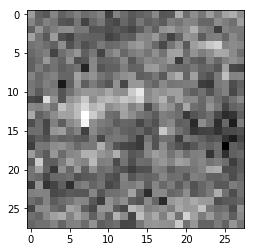

tf.Tensor(
[[-320.74178828 -442.46515802 -342.00325104 -192.91324366 -159.99867542
   -29.34967723 -621.89482692  -95.78430678 -284.0482994   323.84053769]], shape=(1, 10), dtype=float64)
[305.56632505]


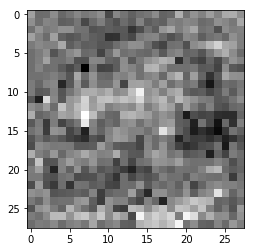

tf.Tensor(
[[-1151.08170367 -1141.68563433  -869.76079915  -281.79904241
   -398.14352587  -346.63667119 -1712.70789997  -418.69937043
   -815.52555347  1094.47365447]], shape=(1, 10), dtype=float64)
[1061.93715301]


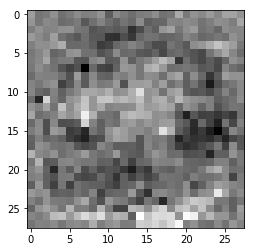

tf.Tensor(
[[-2147.31722092 -1863.74183324 -1688.45133371  -745.44898486
   -711.4460641   -631.04602978 -3283.81561354  -454.78619638
  -1775.06652585  1925.37811604]], shape=(1, 10), dtype=float64)
[1864.11706623]


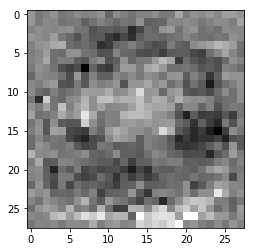

tf.Tensor(
[[-3145.53984957 -2515.58573614 -2539.72576588 -1203.41091648
  -1026.75509488  -818.45342878 -4831.94298804  -528.35145319
  -2763.75290193  2714.53557599]], shape=(1, 10), dtype=float64)
[2609.05528303]


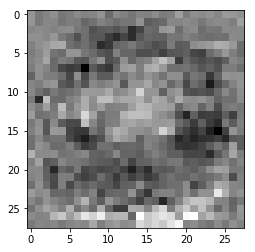

In [165]:
def plot_image(tensor): 
    pixels = am_input.numpy().reshape((28, 28))
    plt.figure(figsize=(4, 4))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

def activation_maximization_loss(predictions, target, inp): 
    print(predictions)
    return tf.reduce_sum(tf.math.multiply(predictions, target)) - lamb * tf.reduce_mean(tf.cast(tf.square(tf.norm(inp)), dtype='double'))

    
am_input = tf.Variable(tf.random.normal((1, 784)), trainable=True)
target = tf.constant([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype='double')
learning_rate = tf.constant([1.0])
lamb = tf.constant([0.01], dtype='double')

iterations = 5
k = len(model.layers) - 1
for i in range(iterations):
    with tf.GradientTape() as tape:
        predictions = feed_through_k_layer(model, am_input, k)
        loss = activation_maximization_loss(predictions, target, am_input)
    print(loss.numpy())
    am_gradient = tape.gradient(loss, am_input) 
    #increase function so add gradient, may need to add learning rate
    am_input.assign_add(learning_rate * am_gradient)
    plot_image(am_input)

In [49]:
test_loss(model(am_input), tf.constant([5])).numpy()

0.1

In [134]:
tf.square(tf.norm(tf.constant([[1, 0.5], [0, 1]]))).numpy()

2.25

## Linear Model

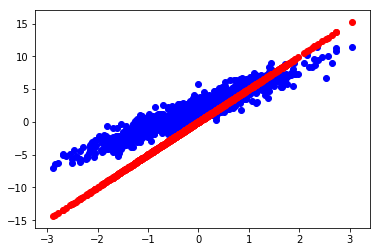

Current loss: 9.750268


In [121]:
class Models(object):
    def __init__(self):
        # Initialize the weights to `5.0` and the bias to `0.0`
        # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

def loss(predicted_y, target_y):
    return tf.reduce_mean(tf.square(predicted_y - target_y))
m = Models()

TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, m(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(m(inputs), outputs).numpy())

In [125]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(m(inputs), outputs)
    dW, db, di = t.gradient(current_loss, [model.W, model.b, inputs])
    print(di)
    m.W.assign_sub(learning_rate * dW)
    m.b.assign_sub(learning_rate * db)

None
Epoch  0: W=5.00 b=0.00, loss=9.75027
None
Epoch  1: W=4.56 b=0.43, loss=6.40089
None
Epoch  2: W=4.22 b=0.77, loss=4.32749
None
Epoch  3: W=3.95 b=1.03, loss=3.04396
None
Epoch  4: W=3.74 b=1.24, loss=2.24937
None
Epoch  5: W=3.57 b=1.41, loss=1.75746
None
Epoch  6: W=3.44 b=1.54, loss=1.45292
None
Epoch  7: W=3.34 b=1.64, loss=1.26438
None
Epoch  8: W=3.26 b=1.73, loss=1.14765
None
Epoch  9: W=3.20 b=1.79, loss=1.07538


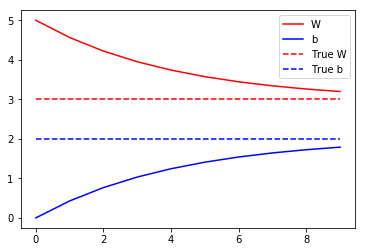

In [126]:
m = Models()
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    Ws.append(m.W.numpy())
    bs.append(m.b.numpy())
    current_loss = loss(m(inputs), outputs)

    train(m, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()